##### Imports

In [1]:
import pandas as pd
import numpy as np
import os

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

%matplotlib inline
from matplotlib import rcParams

import warnings
warnings.filterwarnings('ignore')

##### Paths

In [2]:
dir_artifacts = "/hpf/projects/lsung/projects/mimic4ds/Experiments/baseline/artifacts"
dir_figures = "/hpf/projects/lsung/projects/mimic4ds/Experiments/baseline/figures"
dir_results = "/hpf/projects/lsung/projects/mimic4ds/Experiments/baseline/results"
if not os.path.exists(dir_figures): 
    os.makedirs(dir_figures)
    
# collect results
evaluation_results = pd.read_csv(f"{dir_results}/model_evaluation_0.05.csv")
comparison_results = pd.read_csv(f"{dir_results}/model_comparison_0.05.csv")

#### Plot params

In [3]:
colors = {
    'base':(80,87,94),
    'test':(19,94,150),
    'sig':(0,0,0)#(240,195,60)#(158,194,230)
}
y_axis = {
    'auc':{
        'lim':[0.5, 1],
        'label':'AUROC'
    },
    'auprc':{
        'lim':[0, 0.75],
        'label':'AUPRC'
    },
    'ace_abs_logistic_log':{
        'lim':[-0.05, 0.15],
        'label':'Calibration'
    }
}
titles = {
    'longlos':'Long\nLOS',
    'mortality':'In-Hospital\nMortality',
    'invasivevent':'Invasive\nVentilation',
    'sepsis':'Sepsis'
}

for k,v in colors.items():
    if any([x for x in v if x > 1]):
        colors[k] = [x/255 for x in v]
        
# Plot Vars
tasks = ['mortality','longlos','invasivevent','sepsis']
metrics = ['auc','auprc','ace_abs_logistic_log']

### Plot Main Baseline Results


Evaluation Method: avg performance



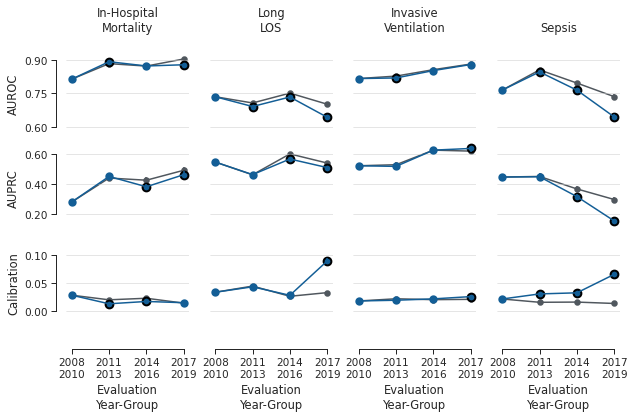

In [4]:
tasks = ['mortality','longlos','invasivevent','sepsis']
metrics = ['auc','auprc','ace_abs_logistic_log']

for method in ['avg']:
    print(f"\nEvaluation Method: {method} performance\n")
    avg_eval = evaluation_results.query("evaluation_method==@method and phase=='test'")
    avg_comp = comparison_results.query("evaluation_method==@method and phase=='test'")

    fig, axes = plt.subplots(
        nrows=len(metrics), 
        ncols=len(tasks),
        figsize=(9,6)
    )
    plt.tight_layout(w_pad=-2,h_pad=-4,rect=[0.05,0.15,1,0.95])

    for r, metric in enumerate(metrics):
        for c, task in enumerate(tasks):

            ## collect results for task & metric
            evals = avg_eval.query("metric==@metric and analysis_id==@task")

            evals_base = evals.query("train_group=='2008 - 2010'")[[
                'metric','train_group','eval_group', 'ci_lower','ci_med','ci_upper'
            ]]
            
            evals_base = evals_base.set_index('eval_group').reindex([
                '2008 - 2010', 
                '2011 - 2013', 
                '2014 - 2016', 
                '2017 - 2019'
            ]).reset_index()
            
            evals_base['ci_upper'] = (evals_base['ci_upper']-evals_base['ci_med']).abs()
            evals_base['ci_lower'] = (evals_base['ci_lower']-evals_base['ci_med']).abs()

            evals_test = evals.query("train_group==eval_group")[[
                'metric','train_group','eval_group', 'ci_lower','ci_med','ci_upper'
            ]]
            
            evals_test = evals_test.set_index('eval_group').reindex([
                '2008 - 2010', 
                '2011 - 2013', 
                '2014 - 2016', 
                '2017 - 2019'
            ]).reset_index()
            
            evals_test['ci_upper'] = (evals_test['ci_upper']-evals_test['ci_med']).abs()
            evals_test['ci_lower'] = (evals_test['ci_lower']-evals_test['ci_med']).abs()

            ## collect stats for task & metric
            comps = avg_comp.query("metric==@metric and analysis_id==@task")
            df_stats = pd.DataFrame(columns=['eval_group',metric])
            
            counter=0
            for group in['2008 - 2010', '2011 - 2013', '2014 - 2016','2017 - 2019']:
                counter+=1
                if group=='2008 - 2010':
                    df_stats.loc[counter,:] = [group, np.nan]
                else:
                    i_comps = comps.query("eval_group==@group")
                    df_stats.loc[counter,:] = [
                        group, 
                        evals_base.query("\
                        eval_group==@group\
                        ")['ci_med'].values[0] if 
                        i_comps['ci_lower'].values[0]*i_comps['ci_upper'].values[0] > 0 else
                        np.nan 
                    ]

            # -- retrained models ----
            axes[r][c].scatter(
                evals_test['eval_group'],
                evals_test['ci_med'],
                s = 20,
                linewidth = 2,
                zorder = 0,
                color = colors['base']
            )
            axes[r][c].errorbar(
                evals_test['eval_group'],
                evals_test['ci_med'],
                evals_test[['ci_lower','ci_upper']].values.T,
                zorder = 0,
                linewidth = 1.5,
                c = colors['base']
            )
            
            # --- baseline models ----
            axes[r][c].scatter(
                evals_base['eval_group'],
                evals_base['ci_med'],
                s = 40,
                linewidth = 2,
                color = colors['test']
            )
            axes[r][c].errorbar(
                evals_base['eval_group'],
                evals_base['ci_med'],
                evals_base[['ci_lower','ci_upper']].values.T,
                linewidth = 1.5,
                c = colors['test']
            )
            
            # Significant difference between "base" and "test" according
            # to bootstrapped comparisons
            sns.scatterplot(
                data = df_stats,
                x = 'eval_group',
                y = metric,
                color = colors['test'],
                edgecolor=colors['sig'],
                linewidth=2,
                ax=axes[r][c],
                s=60
            )

            ## Axes settings
            axes[r][c].set_ylim(y_axis[metric]['lim'])
            axes[r][c].yaxis.set_major_locator(MaxNLocator(nbins=4,prune='both'))
            axes[r][c].grid(which='major', linewidth=0.5, axis='y')
            if r==0:
                axes[r][c].set_title(titles[task])
            if r == len(metrics) - 1:
                axes[r][c].set_xlabel('Evaluation\nYear-Group')
                axes[r][c].set_xticklabels(labels=['2008\n2010','2011\n2013','2014\n2016','2017\n2019'])
            else:
                axes[r][c].set_xticklabels('')
                axes[r][c].set_xlabel('')
                axes[r][c].spines['bottom'].set_color('white')
                axes[r][c].tick_params(axis='x', length=0)
            if c == 0:
                axes[r][c].set_ylabel(y_axis[metric]['label'])
                axes[r][c].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            else:
                axes[r][c].set_yticklabels('')
                axes[r][c].set_ylabel('')
                axes[r][c].spines['left'].set_color('white')
                axes[r][c].tick_params(axis='y', length=0)
    sns.despine(offset=10, trim=True,)
    plt.savefig(f"{dir_figures}/results_{method}.tif", dpi=300)
    plt.show()

## Plot Results By Gender

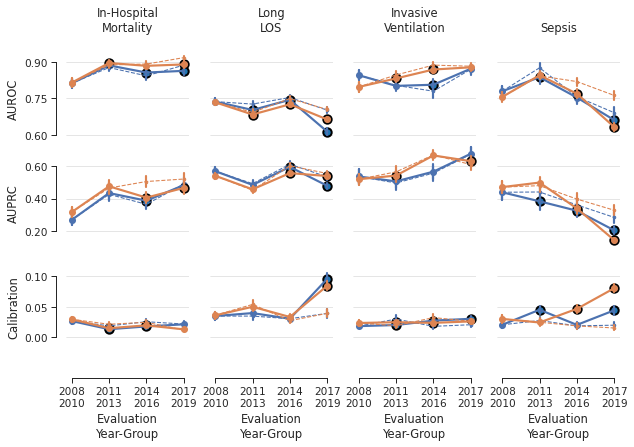

In [8]:
# collect results
evaluation_results = pd.read_csv(f"{dir_results}/model_evaluation_by_gender.csv")
comparison_results = pd.read_csv(f"{dir_results}/model_comparison_by_gender.csv")

tasks = ['mortality','longlos','invasivevent','sepsis']
metrics = ['auc','auprc','ace_abs_logistic_log']

avg_eval = evaluation_results.query("phase=='test'")
avg_comp = comparison_results.query("phase=='test'")

fig, axes = plt.subplots(
    nrows=len(metrics), 
    ncols=len(tasks),
    figsize=(9,6.5)
)
plt.tight_layout(w_pad=-2,h_pad=-4,rect=[0.05,0.15,1,0.95])

for r, metric in enumerate(metrics):
    for c, task in enumerate(tasks):

        ## collect results for task & metric
        evals = avg_eval.query("metric==@metric and analysis_id==@task")

        evals_base = evals.query("train_group=='2008 - 2010'")[[
            'gender','metric','train_group','eval_group', 'ci_lower','ci_med','ci_upper'
        ]].melt(id_vars=['gender','metric','train_group','eval_group'])

        evals_test = evals.query("train_group==eval_group")[[
            'gender','metric','train_group','eval_group', 'ci_lower','ci_med','ci_upper'
        ]].melt(id_vars=['gender','metric','train_group','eval_group'])
        
        ## collect stats for task & metric
        comps = avg_comp.query("metric==@metric and analysis_id==@task")
        df_stats = pd.DataFrame(columns=['gender','eval_group',metric])

        counter=0
        for dem_cat in ['M','F']:
            for group in['2008 - 2010', '2011 - 2013', '2014 - 2016','2017 - 2019']:
                counter+=1
                if group=='2008 - 2010':
                    df_stats.loc[counter,:] = [dem_cat, group, np.nan]
                else:
                    i_comps = comps.query("gender==@dem_cat and eval_group==@group")
                    df_stats.loc[counter,:] = [
                        dem_cat,
                        group, 
                        evals_base.query("\
                        gender==@dem_cat and \
                        eval_group==@group and \
                        variable=='ci_med'\
                        ")['value'].values[0] if 
                        i_comps['ci_lower'].values[0]*i_comps['ci_upper'].values[0] > 0 else
                        np.nan 
                    ]

        ## plot

        # Models trained and tested on the same year-group
        sns.pointplot(
            data = evals_test,
            x = 'eval_group',
            y = 'value',
            hue = 'gender',
            ax = axes[r][c],
            #color=colors['base'],
            linestyles='--',
            palette='deep',
            scale = 0.5,
            alphas=0.3,
            order = [
                '2008 - 2010', 
                '2011 - 2013', 
                '2014 - 2016', 
                '2017 - 2019'],
        )

        # Models trained on 2008 - 2010 and tested on all year-groups
        sns.pointplot(
            data = evals_base,
            x = 'eval_group',
            y = 'value',
            hue = 'gender',
            palette='deep',
            ax = axes[r][c],
            #color = colors['test'],
            order = [
                '2008 - 2010', 
                '2011 - 2013', 
                '2014 - 2016', 
                '2017 - 2019'],
        )
        
        # Significant difference between "base" and "test" according
        # to bootstrapped comparisons
        sns.scatterplot(
            data = df_stats,
            x = 'eval_group',
            y = metric,
            edgecolor='black',
            linewidth=2,
            ax=axes[r][c],
            s=70
        )

        ## Axes settings
        axes[r][c].get_legend().remove()
        axes[r][c].set_ylim(y_axis[metric]['lim'])
        axes[r][c].yaxis.set_major_locator(MaxNLocator(nbins=4,prune='both'))
        axes[r][c].grid(which='major', linewidth=0.5, axis='y')
        if r==0:
            axes[r][c].set_title(titles[task])
        if r == len(metrics) - 1:
            axes[r][c].set_xlabel('Evaluation\nYear-Group')
            axes[r][c].set_xticklabels(labels=['2008\n2010','2011\n2013','2014\n2016','2017\n2019'])
        else:
            axes[r][c].set_xticklabels('')
            axes[r][c].set_xlabel('')
            axes[r][c].spines['bottom'].set_color('white')
            axes[r][c].tick_params(axis='x', length=0)
        if c == 0:
            axes[r][c].set_ylabel(y_axis[metric]['label'])
            axes[r][c].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        else:
            axes[r][c].set_yticklabels('')
            axes[r][c].set_ylabel('')
            axes[r][c].spines['left'].set_color('white')
            axes[r][c].tick_params(axis='y', length=0)
sns.despine(offset=10, trim=True,)
plt.savefig(f"{dir_figures}/results_by_gender.tif", dpi=300)
plt.show()